In [51]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, RepeatedKFold

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

dtrain = pd.read_csv('zhengqi_train.txt', sep='\t')
dtest = pd.read_csv('zhengqi_test.txt', sep='\t')
dfull = pd.concat([dtrain, dtest], ignore_index=True, sort=False)
print('训练集大小: ', np.shape(dtrain))
print('测试集大小: ', np.shape(dtest))

训练集大小:  (2888, 39)
测试集大小:  (1925, 38)


Text(0.5, 1.0, 'DATA-FULL')

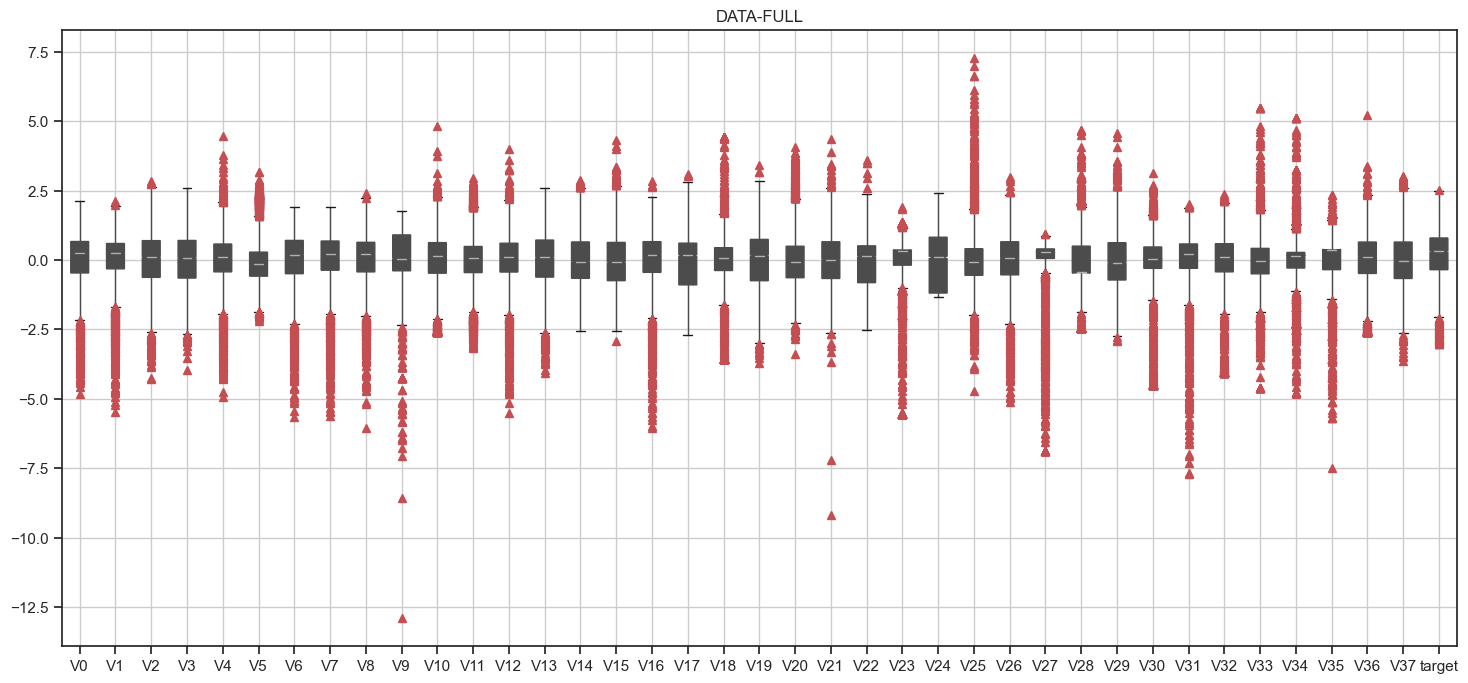

In [52]:
plt.figure(figsize=(18,8),dpi=100)
dfull.boxplot(sym='r^', patch_artist=True, notch=True)
plt.title('DATA-FULL')


In [53]:
# 查看数据缺失情况

print('缺失值统计：')
print(dfull.apply(lambda x: sum(x.isnull())))


缺失值统计：
V0           0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
V8           0
V9           0
V10          0
V11          0
V12          0
V13          0
V14          0
V15          0
V16          0
V17          0
V18          0
V19          0
V20          0
V21          0
V22          0
V23          0
V24          0
V25          0
V26          0
V27          0
V28          0
V29          0
V30          0
V31          0
V32          0
V33          0
V34          0
V35          0
V36          0
V37          0
target    1925
dtype: int64


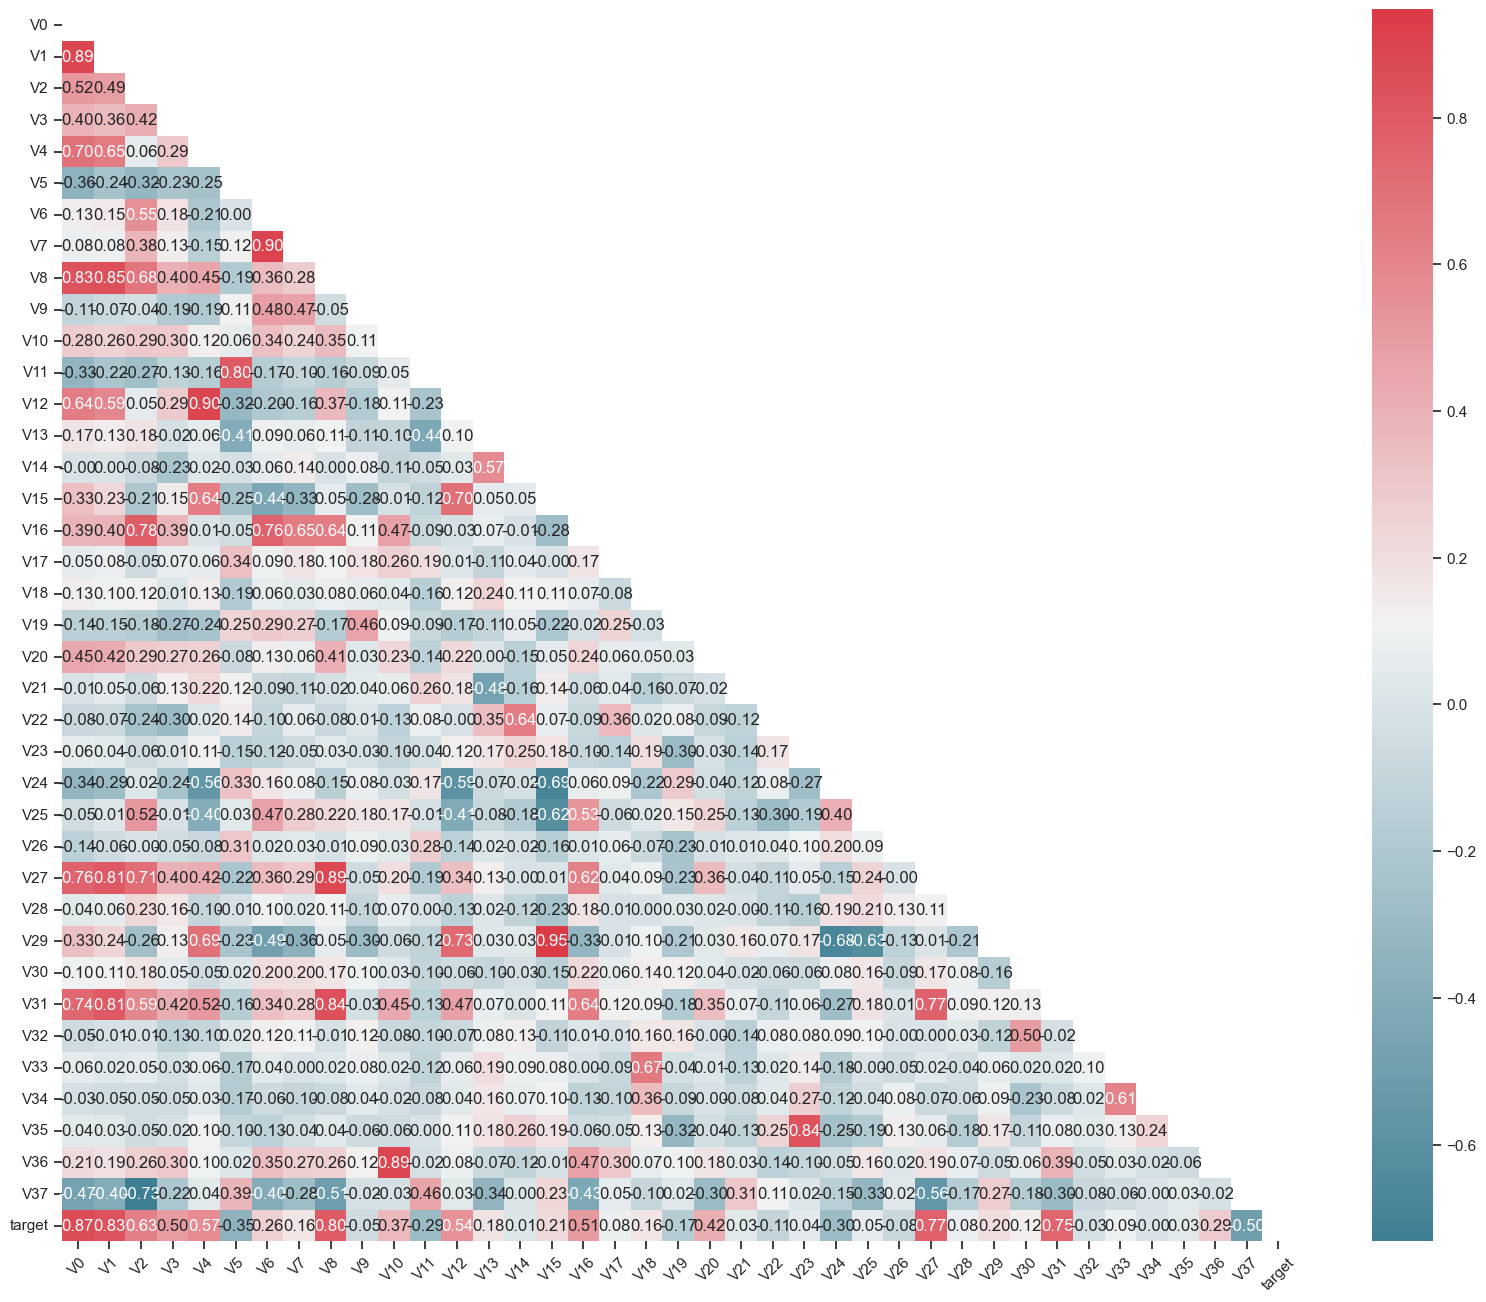

In [54]:
def heatmap(df):
    plt.figure(figsize=(20,16), dpi=100)
    cols = df.columns.tolist()
    mcorr = df[cols].corr(method = 'spearman')
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(mcorr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True              # 角分线右侧为True
    g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')
    plt.xticks(rotation=45)
    return mcorr

dtrain_mcorr = heatmap(dtrain)


In [55]:
# 删除dfull表中指定的列
def drop_var(var_lst):
    dfull.drop(var_lst, axis=1, inplace=True)

# 将dfull重新分割为dtrain核dtest
def split_dfull():
    dtrain = dfull[dfull['target'].notnull()]
    dtest = dfull[dfull['target'].isnull()]
    dtest.drop('target', axis=1, inplace=True)
    return dtrain, dtest


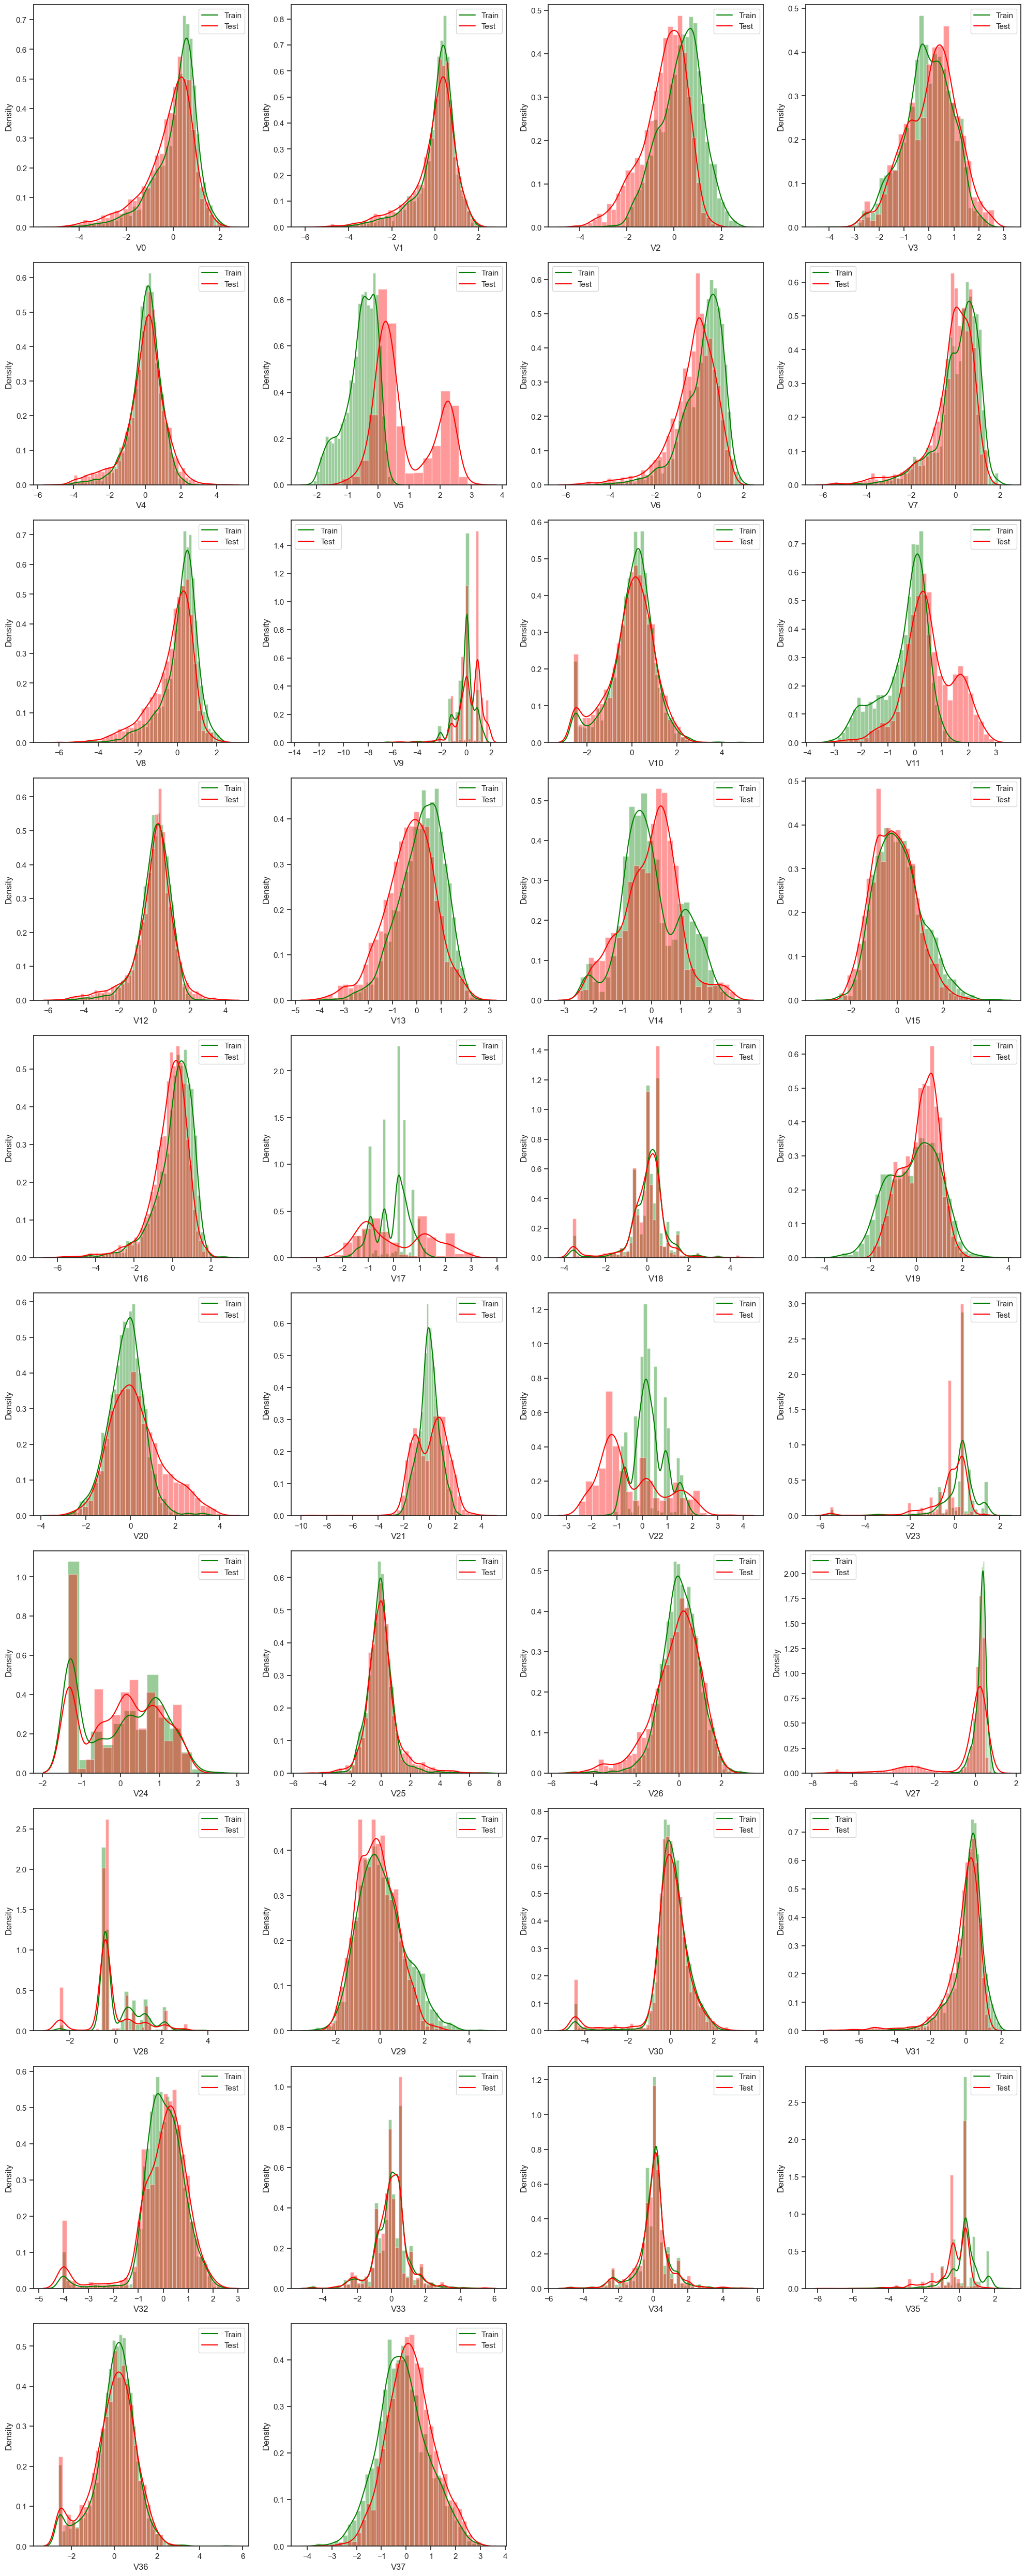

In [56]:


plt.figure(figsize=(20,50),dpi=100)
for i in range(38):
    plt.subplot(10,4,i+1)
    sns.distplot(dtrain.iloc[:,i], color='green')
    sns.distplot(dtest.iloc[:,i], color='red')
    plt.legend(['Train','Test'])
plt.tight_layout()


In [57]:
drop_var(['V5','V9','V11','V17','V20','V21','V22','V27','V28'])
dtrain, dtest = split_dfull()


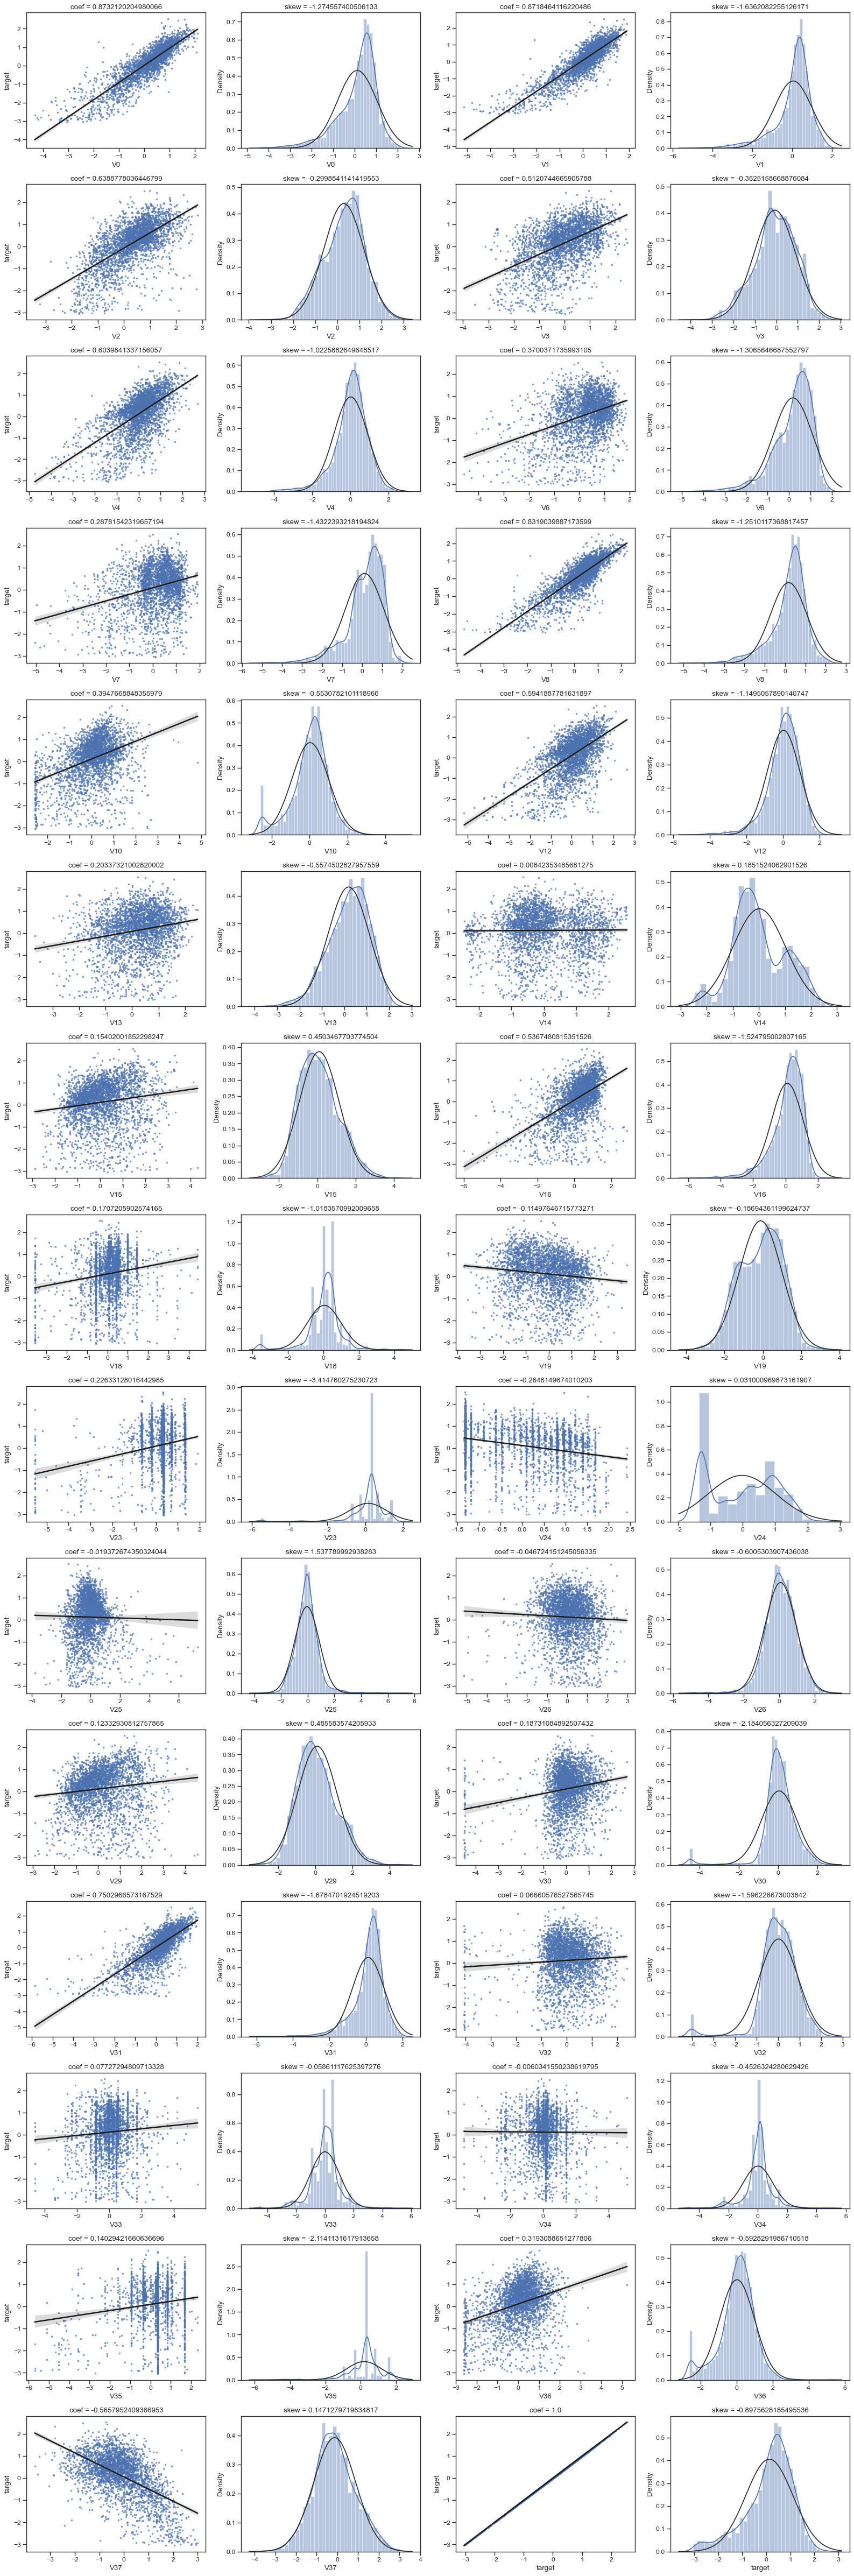

In [58]:
plt.figure(figsize=(20,60),dpi=80)
i = 0
for col in dtrain.columns:
    i += 1
    plt.subplot(15,4,i)
    sns.regplot(x=col, y='target', data = dtrain,
               scatter_kws = {'marker': '.', 's': 5, 'alpha': .6},
               line_kws = {'color': 'k'})
    coef = np.corrcoef(dtrain[col], dtrain['target'])[0][1]
    plt.title(f'coef = {coef}')
    plt.xlabel(col)
    plt.ylabel('target')

    i += 1
    plt.subplot(15,4,i)
    sns.distplot(dtrain[col], fit = stats.norm)
    plt.title(f'skew = {stats.skew(dtrain[col])}')
    plt.xlabel(col)

plt.tight_layout()


In [59]:
drop_var(['V14','V25','V26','V32','V33','V34','V35'])
dtrain, dtest = split_dfull()


In [60]:
# 分布呈明显左偏的特征
piantai = ['V0','V1','V6','V7','V8','V12','V16','V31']

# 创建函数——找到令偏态系数绝对值最小的对数转换的底
def find_min_skew(data):
    subs = list(np.arange(1.01,2,0.01))
    skews = []
    for x in subs:
        skew = abs(stats.skew(np.power(x,data)))
        skews.append(skew)
    min_skew = min(skews)
    i = skews.index(min_skew)
    return subs[i], min_skew


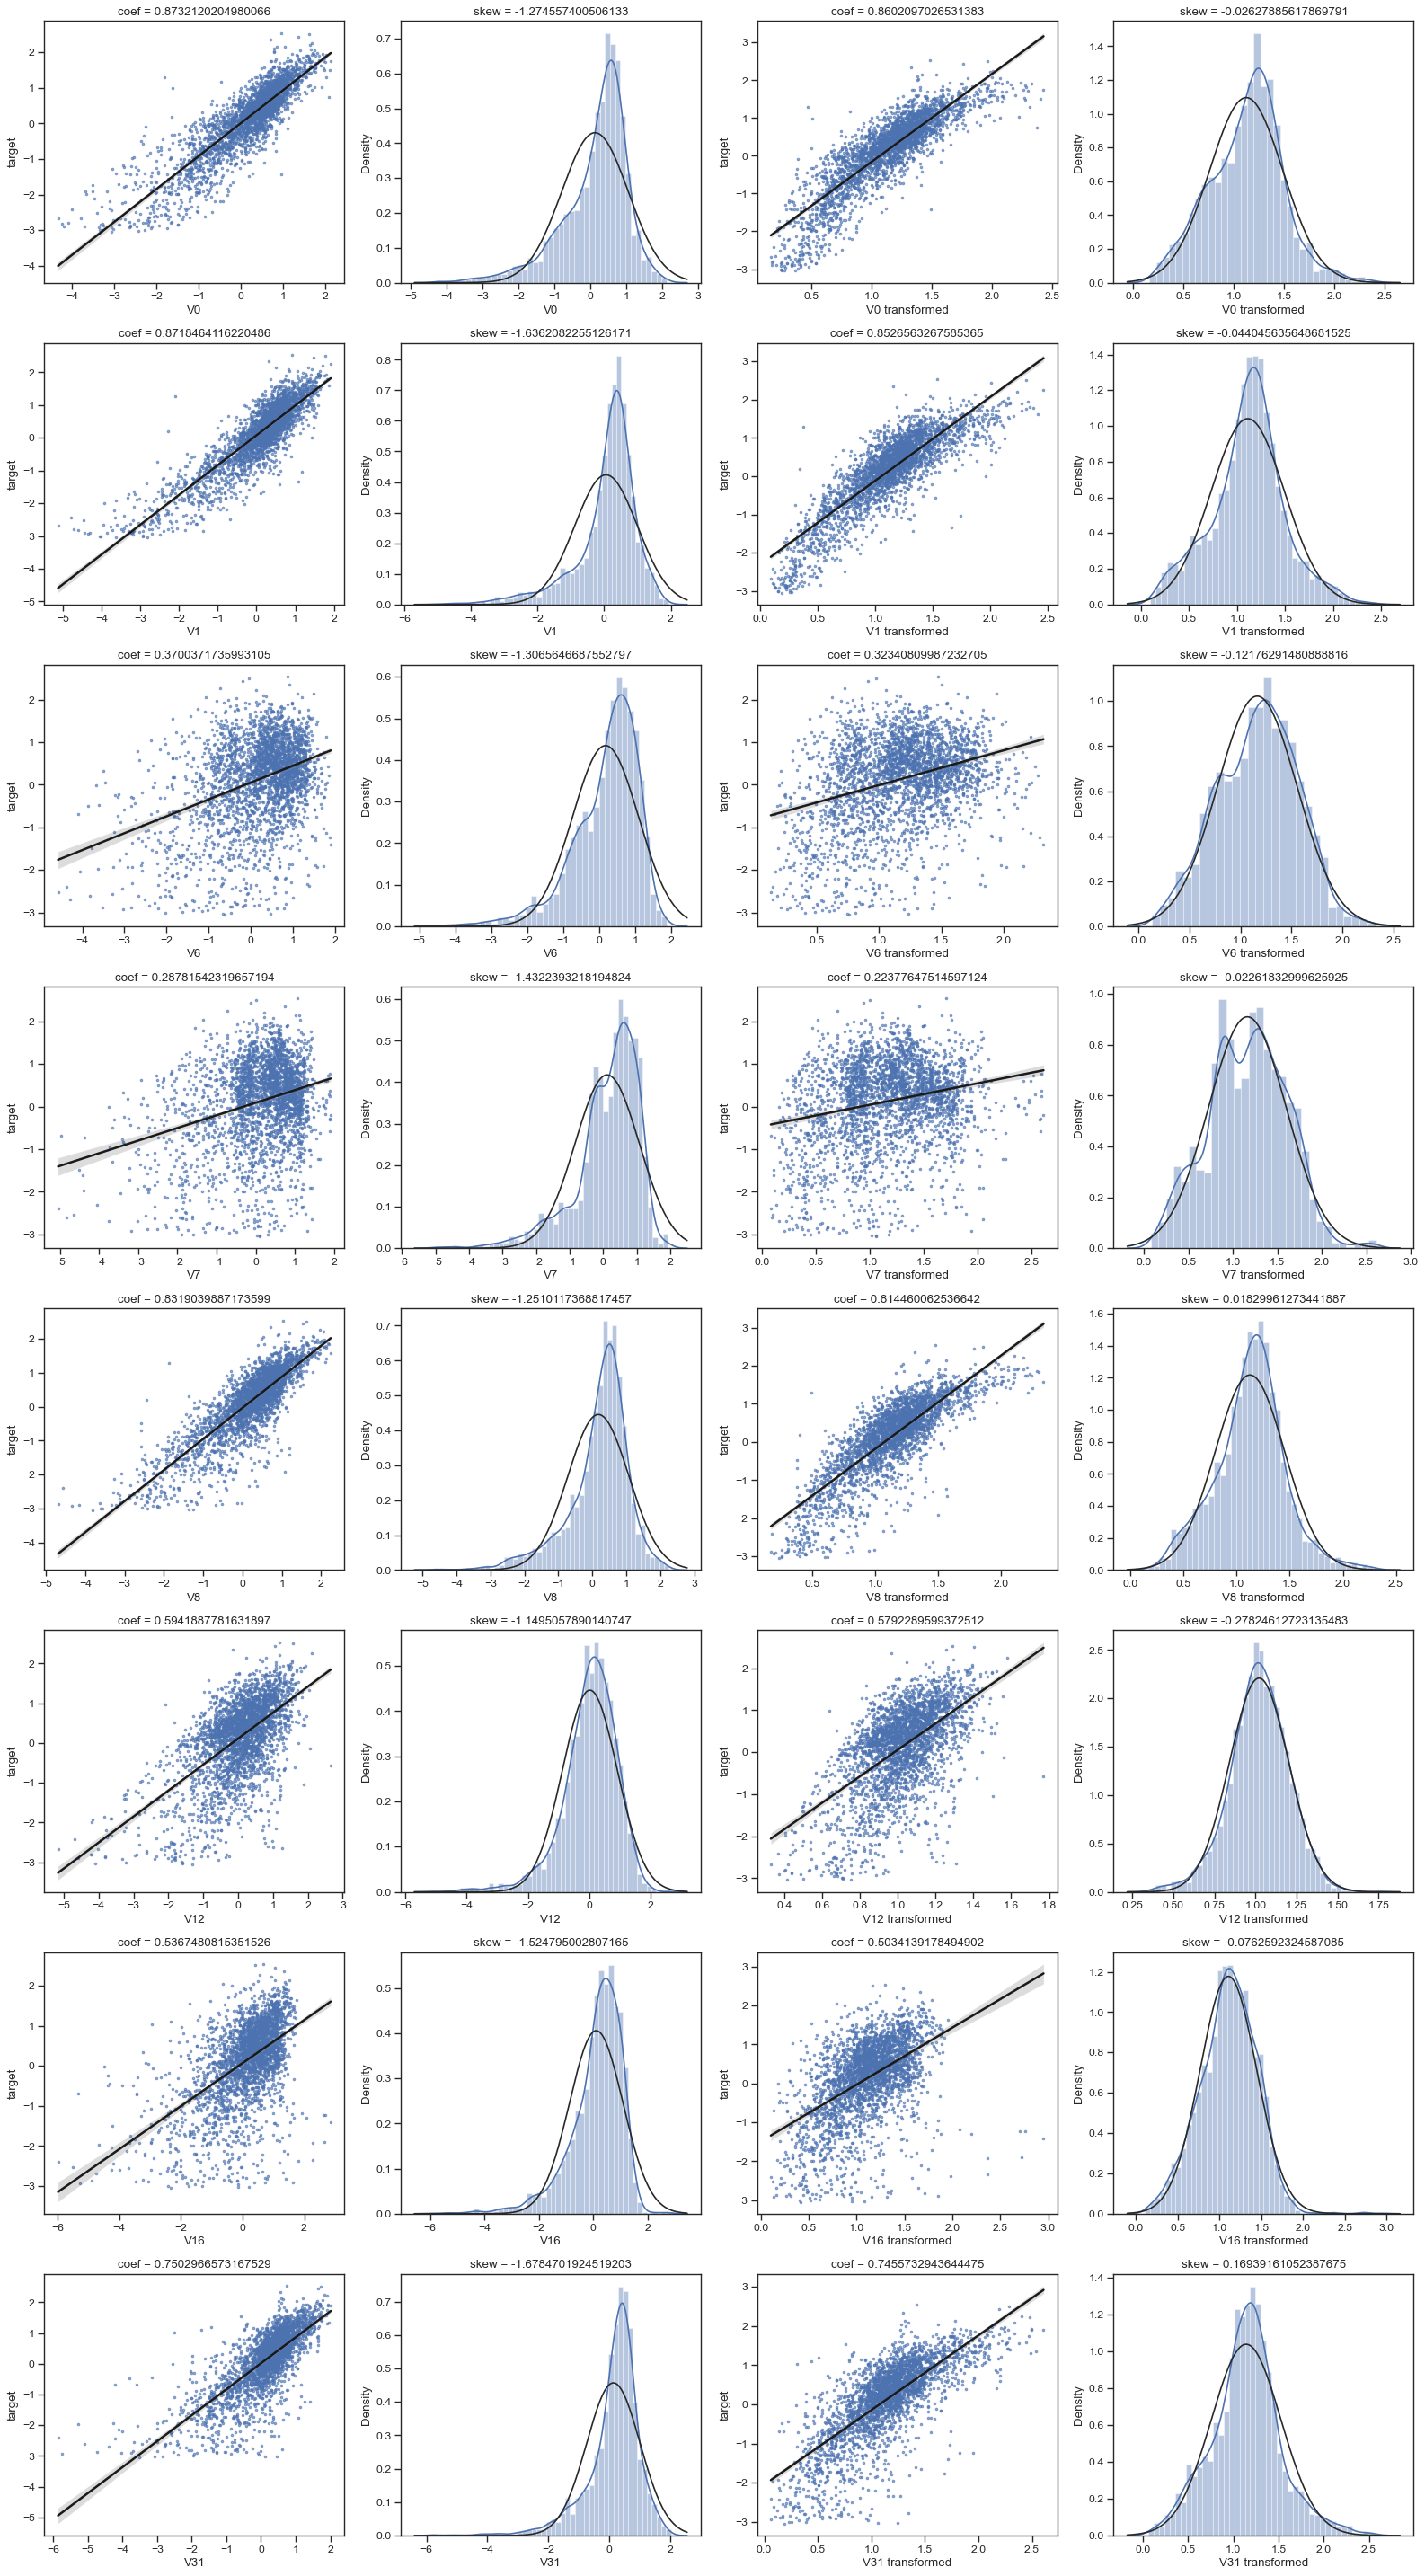

In [61]:
plt.figure(figsize=(20,36), dpi=80)

i = 0
for col in piantai:

    # 正态化之前的偏态特征与结果变量相关图与正态分布图
    i += 1
    plt.subplot(8,4,i)
    sns.regplot(x=col,y= 'target', data = dtrain,
               scatter_kws = {'marker': '.', 's': 5, 'alpha': .6},
               line_kws = {'color': 'k'})
    coef = np.corrcoef(dtrain[col], dtrain['target'])[0][1]
    plt.title(f'coef = {coef}')
    plt.xlabel(col)
    plt.ylabel('target')

    i += 1
    plt.subplot(8,4,i)
    sns.distplot(dtrain[col], fit = stats.norm)
    plt.title(f'skew = {stats.skew(dtrain[col])}')
    plt.xlabel(col)

    # 找到合适的底数，对dtrain的偏态特征进行对数转换
    sub = find_min_skew(dfull[col])[0]
    dtrain[col] = np.power(sub, dtrain[col])

    # 对数转换之后特征与结果变量相关图与正态分布图
    i += 1
    plt.subplot(8,4,i)
    sns.regplot(x=col, y='target', data = dtrain,
               scatter_kws = {'marker': '.', 's': 5, 'alpha': .6},
               line_kws = {'color': 'k'})
    coef = np.corrcoef(dtrain[col], dtrain['target'])[0][1]
    plt.title(f'coef = {coef}')
    plt.xlabel(col+' transformed')
    plt.ylabel('target')

    i += 1
    plt.subplot(8,4,i)
    sns.distplot(dtrain[col], fit = stats.norm)
    plt.title(f'skew = {stats.skew(dtrain[col])}')
    plt.xlabel(col+' transformed')

plt.tight_layout()


In [62]:
for col in piantai:
    sub = find_min_skew(dfull[col])[0]
    dfull[col] = np.power(sub, dfull[col])
dtrain, dtest = split_dfull()

In [63]:
dfull.iloc[:,:-1] = dfull.iloc[:,:-1].apply(lambda x: (x-x.mean())/x.std())
dtrain, dtest = split_dfull()


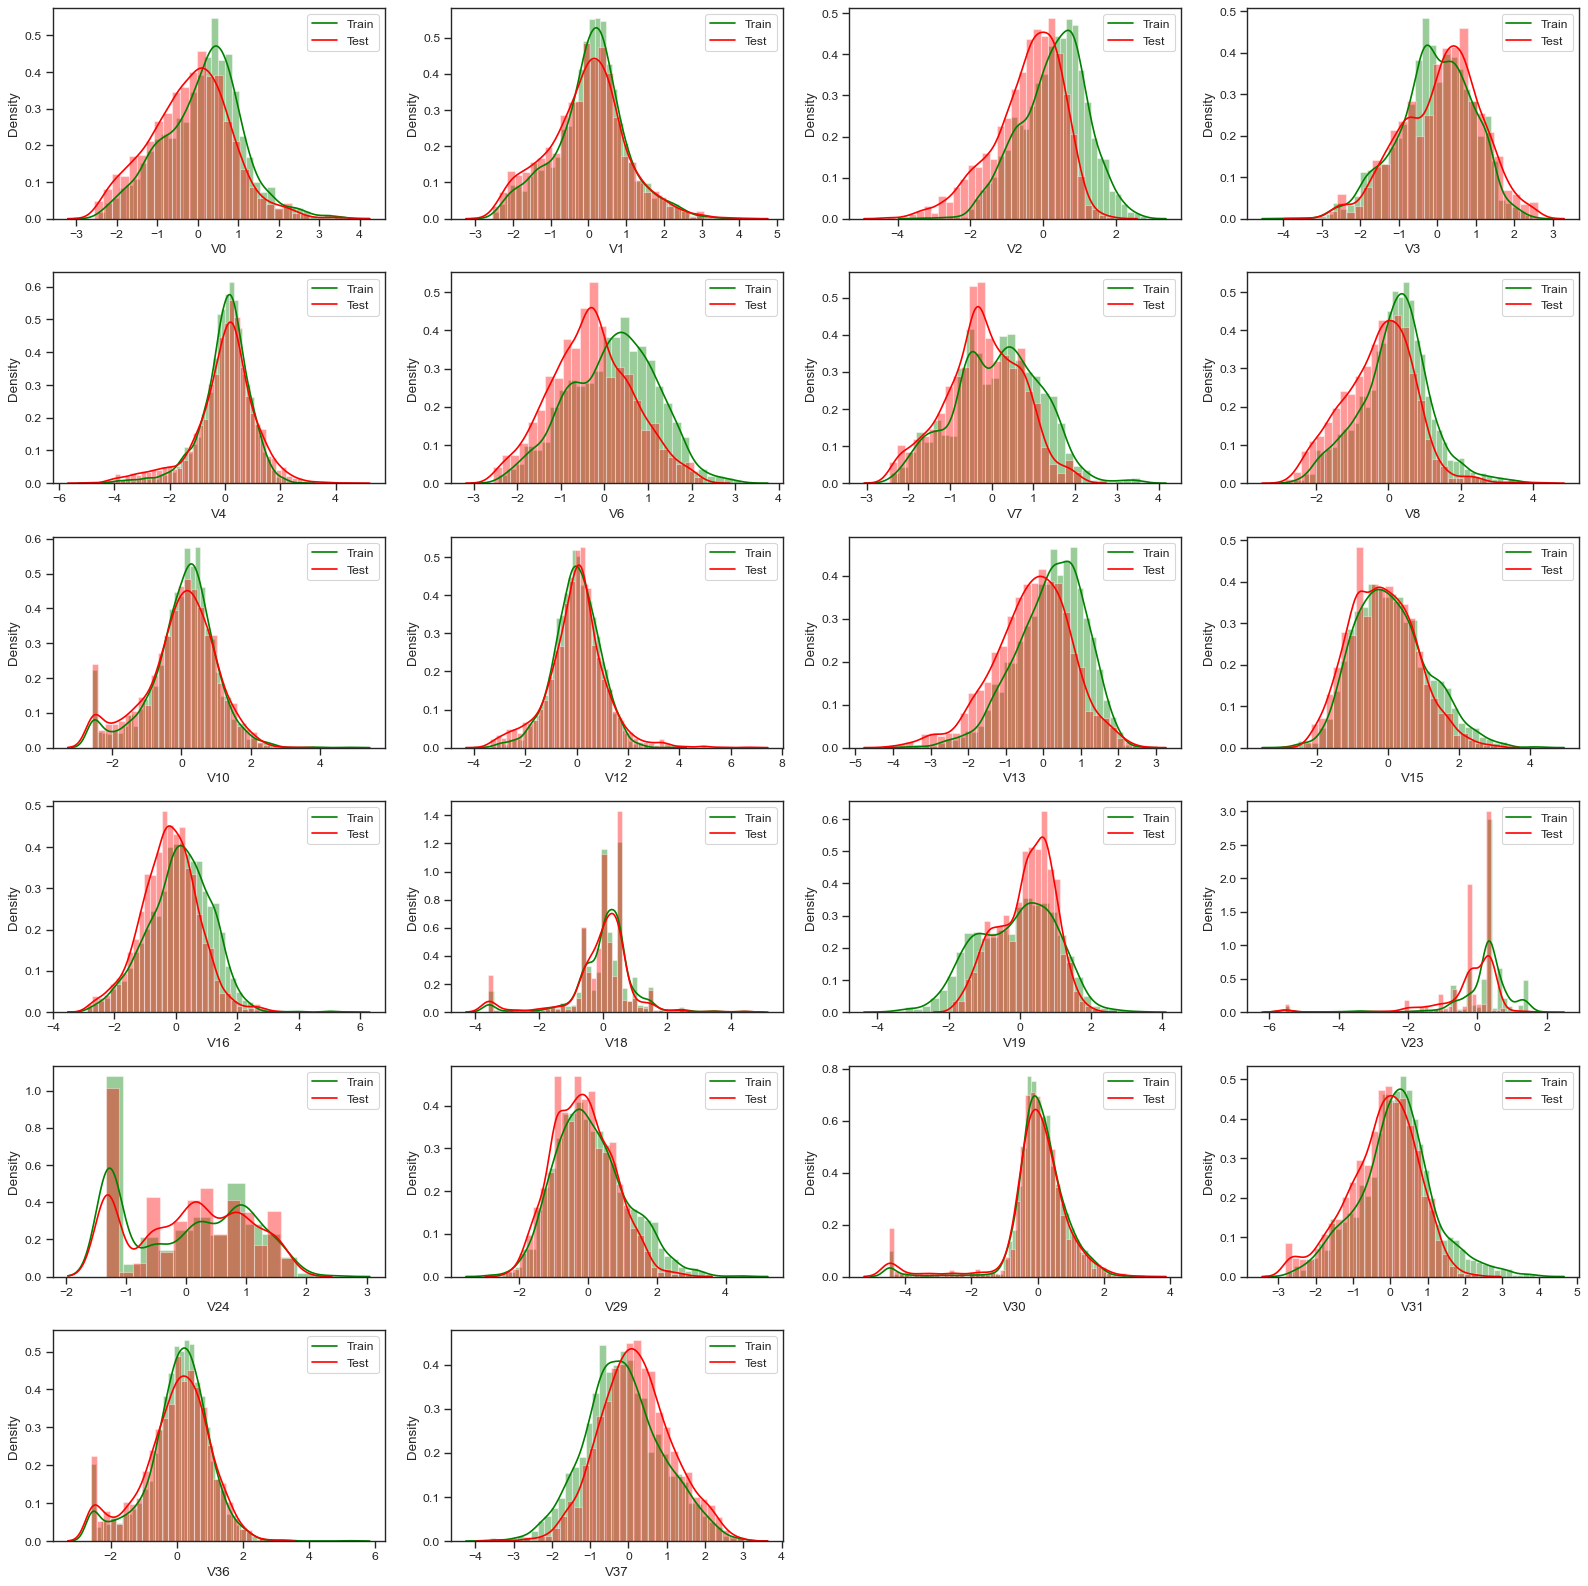

In [64]:
plt.figure(figsize=(20,20),dpi=80)
for i in range(22):
    plt.subplot(6,4,i+1)
    sns.distplot(dtrain.iloc[:,i], color='green')
    sns.distplot(dtest.iloc[:,i], color='red')
    plt.legend(['Train','Test'])
plt.tight_layout()


In [65]:
X = np.array(dtrain.iloc[:,:-1])
y = np.array(dtrain['target'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)


In [66]:
def score(y, y_pred):
	# 计算均方误差 MSE
    print('MSE = {0}'.format(mean_squared_error(y, y_pred)))
    # 计算模型决定系数 R2
    print('R2 = {0}'.format(r2_score(y, y_pred)))

    # 计算预测残差，找异常点
    y = pd.Series(y)
    y_pred = pd.Series(y_pred, index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid) / std_resid
    n_outliers = sum(abs(z)>3)

    # 图一：真实值vs预计值
    plt.figure(figsize=(18,5), dpi=80)
    plt.subplot(131)
    plt.plot(y, y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))

    # 图二：残差分布散点图
    plt.subplot(132)
    plt.plot(y, y-y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('resid')
    plt.ylim([-3,3])
    plt.title('std_resid = {:.3f}'.format(std_resid))

    # 图三：残差z得分直方图
    plt.subplot(133)
    sns.distplot(z, bins=50)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))
    plt.tight_layout()


best_alpha = 10.0
MSE = 0.1239647468701295
R2 = 0.8695133658493563


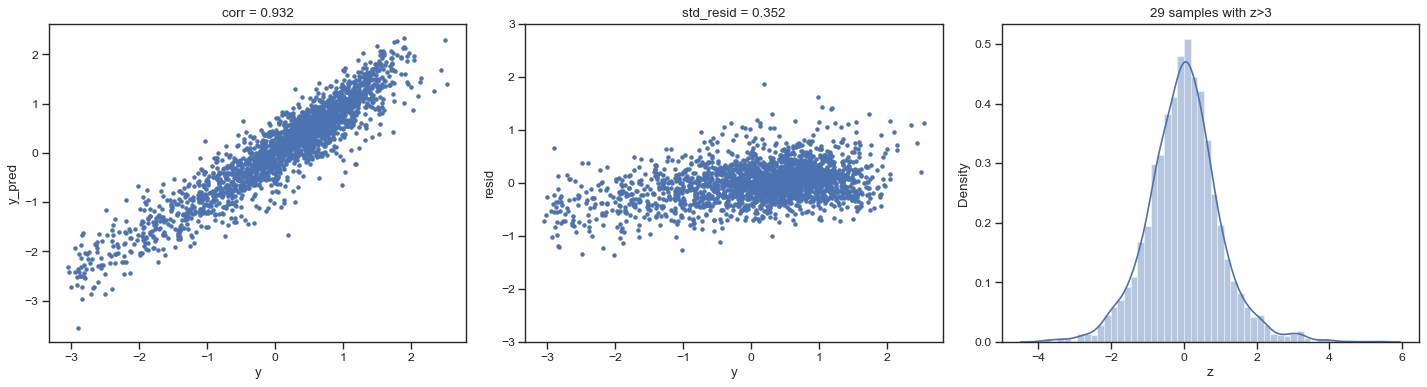

In [67]:
# 利用RidgeCV函数自动寻找最优参数
ridge = RidgeCV()
ridge.fit(X_train, y_train)
print('best_alpha = {0}'.format(ridge.alpha_))

y_pred = ridge.predict(X_train)
score(y_train, y_pred)


29 Outliers:
[89, 407, 652, 725, 768, 797, 829, 875, 907, 1123, 1190, 1195, 1236, 1295, 1324, 1366, 1544, 1641, 1662, 1706, 1718, 1833, 1983, 2013, 2022, 2025, 2084, 2124, 2279]


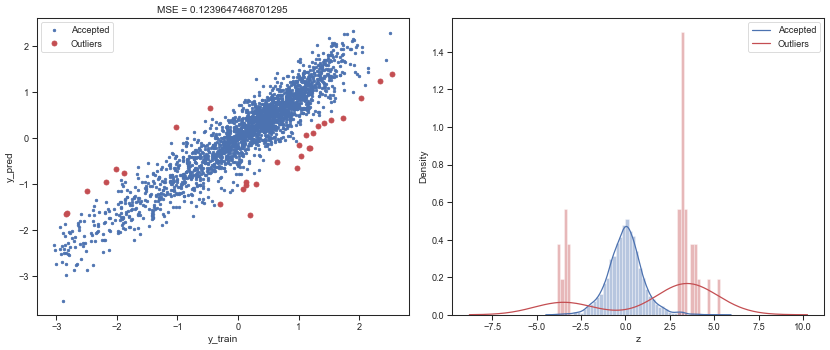

In [68]:
resid = y_train - y_pred
resid = pd.Series(resid, index=range(len(y_train)))
resid_z = (resid-resid.mean()) / resid.std()
outliers = resid_z[abs(resid_z)>3].index
print(f'{len(outliers)} Outliers:')
print(outliers.tolist())

plt.figure(figsize=(14,6),dpi=60)

plt.subplot(121)
plt.plot(y_train, y_pred, '.')
plt.plot(y_train[outliers], y_pred[outliers], 'ro')
plt.title(f'MSE = {mean_squared_error(y_train,y_pred)}')
plt.legend(['Accepted', 'Outliers'])
plt.xlabel('y_train')
plt.ylabel('y_pred')

plt.subplot(122)
sns.distplot(resid_z, bins = 50)
sns.distplot(resid_z.loc[outliers], bins = 50, color = 'r')
plt.legend(['Accepted', 'Outliers'])
plt.xlabel('z')
plt.tight_layout()


best_alpha = 0.0008161390644852558
MSE = 0.13336459813562107
R2 = 0.8716573375011556


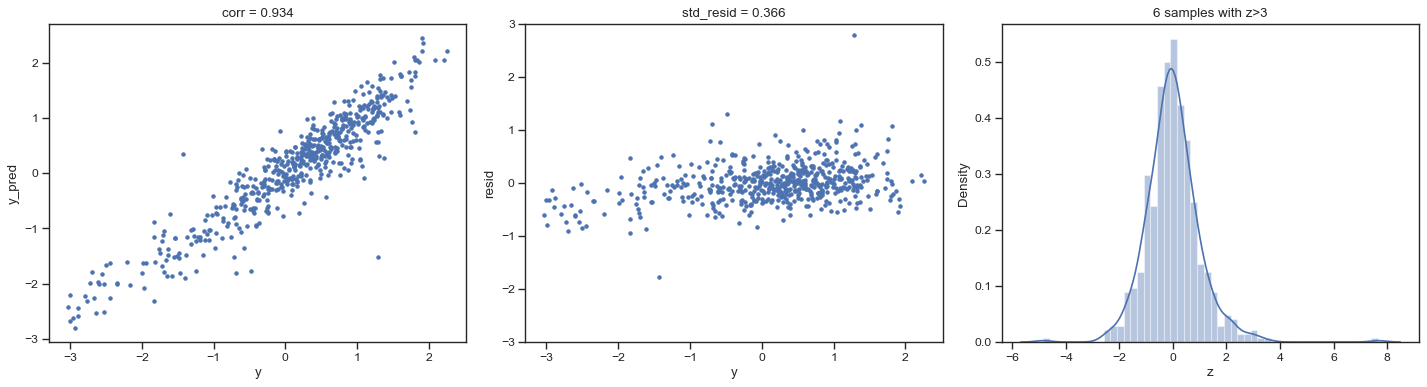

In [73]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print('best_alpha = {0}'.format(lasso.alpha_))

pred_lasso = lasso.predict(X_valid)
score(y_valid, pred_lasso)


In [76]:

models = [lasso]
model_names = ['Lasso']
plt.figure(figsize=(20,5))

for i,m in enumerate(models):
    train_sizes, train_scores, test_scores = learning_curve(m, X, y, cv=5, scoring='neg_mean_squared_error',
                                                            train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.subplot(1,3,i+1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Train')
    plt.plot(train_sizes, test_scores_mean, '^-', label='Test')
    plt.xlabel('Train_size')
    plt.ylabel('Score')
    plt.ylim([0,0.35])
    plt.title(model_names[i], fontsize=16)
    plt.legend()
    plt.grid()

plt.tight_layout()


UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-19: ordinal not in range(128)

<Figure size 2000x500 with 0 Axes>

In [77]:
X_test = np.array(dtest)
ans_lasso = lasso.predict(X_test)
ans_mix = ans_lasso
pd.Series(ans_mix).to_csv('正态+标准化.txt', sep='\t', index=False)
print('Finished!')


Finished!
